# Statistical Analysis <a id='stats'></a>

[Data quality](#qa) <br>
[Behavioral results](#beh) <br>
[Brain graph metrics](#graph) <br>
[Mean FC](#fc) <br>
[Regression analyses](#reg) <br>

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

pd.set_option("display.precision", 3)
sns.set_palette('Set1')

homeDir = os.path.expanduser("~")
homeDir

'/Users/mcmahonmc'

In [2]:
df = pd.read_csv('./data/03_fc_data.csv')
df = df.set_index('subject')
print(df.shape)


modVars = [col for col in df.columns if col.startswith('q_')]
pcVars = [i for i in df.columns if 'pc_' in i and 'dmn_fpn' not in i]
fcVars = [col for col in df.columns if 'fc' in col]
memVars = [col for col in df.columns if 'acc_' in col or 'rt_c_' in col]
edgeVars = [col for col in df if col.startswith('net')]
pcaVars = ['C1', 'C2', 'C3']
sleepVars = ['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep']

df.head()

(130, 94)


/usr/local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,Group,GroupBin,age,sex,actamp,actphi,sleep_time_mean_sleep,total_ac_mean_active,efficiency_mean_sleep,q_global_cue,...,acc_mean_learning,acc_mean_test,acc_std_learning,acc_std_test,rt_c_mean_learning,rt_c_mean_test,rt_c_std_learning,rt_c_std_test,acc_mean_test_log,acc_mean_learning_log
subject,,,,,,,,,,,,,,,,,,,,,
30003,Young Adults,0,22.0,Female,NaN,NaN,222.071,434502.429,61.786,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30004,Young Adults,0,27.0,Female,1.560,14.74,380.643,268200.429,87.394,0.398,...,0.917,0.972,0.280,0.167,1230.242,2299.286,381.311,145.936,-0.012,-0.038
30008,Young Adults,0,18.0,Female,1.564,15.47,419.714,258591.143,83.851,0.470,...,0.944,0.944,0.232,0.232,1660.941,2475.176,641.488,204.529,-0.025,-0.025
30009,Young Adults,0,25.0,Female,1.900,14.61,394.000,459317.286,86.574,0.359,...,0.972,0.972,0.167,0.167,1562.514,2373.486,532.893,380.752,-0.012,-0.012
30012,Young Adults,0,30.0,Male,1.670,15.22,409.000,378916.857,88.383,NaN,...,0.917,0.806,0.280,0.401,1971.121,2503.034,928.409,376.663,-0.094,-0.038


## Data quality <a id='qa'></a>

In [3]:
print(df.shape)
df = df.dropna(subset=['acc_mean_test'])
print(df.shape)
df = df[(df['acc_mean_learning'] > 0.33)]
print(df.shape)
df = df[(df['acc_mean_test'] > 0.56)]
print(df.shape)

(130, 94)
(100, 94)
(99, 94)
(97, 94)


In [4]:
df.isna().sum()

Group                    0
GroupBin                 0
age                      0
sex                      0
actamp                   4
                        ..
rt_c_mean_test           0
rt_c_std_learning        0
rt_c_std_test            0
acc_mean_test_log        0
acc_mean_learning_log    0
Length: 94, dtype: int64

In [5]:
df[df['Group'] == 'Older Adults'].isna().sum()

Group                    0
GroupBin                 0
age                      0
sex                      0
actamp                   3
                        ..
rt_c_mean_test           0
rt_c_std_learning        0
rt_c_std_test            0
acc_mean_test_log        0
acc_mean_learning_log    0
Length: 94, dtype: int64

In [6]:
ya = df[df['Group'] == 'Young Adults']
ya = ya.fillna(ya.mean())

oa = df[df['Group'] == 'Older Adults']
oa = oa.fillna(oa.mean())

dfFill = pd.concat((ya, oa))
print(df.shape)
dfFill.head()

(97, 94)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_48229/852004413.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ya = ya.fillna(ya.mean())
/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_48229/852004413.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  oa = oa.fillna(oa.mean())


,Group,GroupBin,age,sex,actamp,actphi,sleep_time_mean_sleep,total_ac_mean_active,efficiency_mean_sleep,q_global_cue,...,acc_mean_learning,acc_mean_test,acc_std_learning,acc_std_test,rt_c_mean_learning,rt_c_mean_test,rt_c_std_learning,rt_c_std_test,acc_mean_test_log,acc_mean_learning_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,Young Adults,0,27.0,Female,1.560,14.740,380.643,268200.429,87.394,0.398,...,0.917,0.972,0.280,0.167,1230.242,2299.286,381.311,145.936,-0.012,-0.038
30008,Young Adults,0,18.0,Female,1.564,15.470,419.714,258591.143,83.851,0.470,...,0.944,0.944,0.232,0.232,1660.941,2475.176,641.488,204.529,-0.025,-0.025
30009,Young Adults,0,25.0,Female,1.900,14.610,394.000,459317.286,86.574,0.359,...,0.972,0.972,0.167,0.167,1562.514,2373.486,532.893,380.752,-0.012,-0.012
30012,Young Adults,0,30.0,Male,1.670,15.220,409.000,378916.857,88.383,0.363,...,0.917,0.806,0.280,0.401,1971.121,2503.034,928.409,376.663,-0.094,-0.038
30015,Young Adults,0,26.0,Male,1.588,14.058,404.357,298735.571,89.586,0.337,...,0.972,0.889,0.167,0.319,2043.543,2608.312,1221.283,571.810,-0.051,-0.012


In [7]:
df.acc_mean_test.min()

0.638888888888889

## Behavioral results <a id='beh'></a>

### Task

In [8]:
df[['Group'] + [c for c in memVars if 'mean' in c]].groupby('Group').describe().T.round(3)[['Young Adults', 'Older Adults']].to_latex('./results/behresults.tex', index=True)

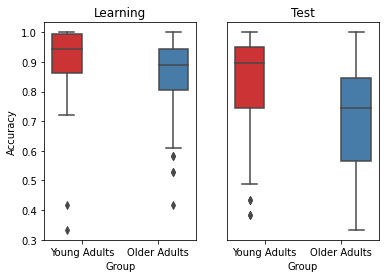

In [9]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='acc_mean_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='acc_mean_test', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/accuracy.png', dpi=300)

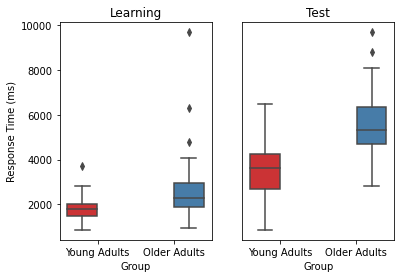

In [10]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='rt_c_mean_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Response Time (ms)'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='rt_c_mean_test', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rtc.png', dpi=300)

In [11]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_mean_learning'].dropna(), df[df['Group'] == "Older Adults"]['acc_mean_learning'].dropna())

Ttest_indResult(statistic=2.2249498084572727, pvalue=0.028451330994538764)

In [12]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_mean_learning'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_mean_learning'].dropna())

Ttest_indResult(statistic=-3.9808930662216735, pvalue=0.00013429559822562392)

In [13]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_mean_test'].dropna(), df[df['Group'] == "Older Adults"]['acc_mean_test'].dropna())

Ttest_indResult(statistic=3.01370641136549, pvalue=0.003308696490765574)

In [14]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_mean_test'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_mean_test'].dropna())

Ttest_indResult(statistic=-7.203700263088297, pvalue=1.3781895632862566e-10)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='acc_mean_learning_log', ylabel='Density'>

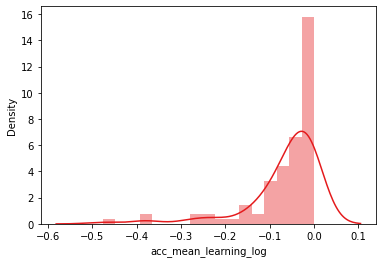

In [15]:
sns.distplot(df['acc_mean_learning_log'].dropna())

### RAR/Sleep

In [16]:
stats.ttest_ind(df[df['sex'] == "Male"]['actamp'].dropna(), df[df['sex'] == "Female"]['actamp'].dropna())

Ttest_indResult(statistic=-1.373520451761355, pvalue=0.17296505449554478)

In [17]:
stats.ttest_ind(df[df['sex'] == "Male"]['actphi'].dropna(), df[df['sex'] == "Female"]['actphi'].dropna())

Ttest_indResult(statistic=0.7743026902989425, pvalue=0.440737163116526)

In [18]:
pg.corr(df['actamp'], df['sleep_time_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,93,0.004,"[-0.2, 0.21]",0.968,0.13,0.05


In [19]:
pg.corr(df['actamp'], df['efficiency_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,93,0.25,"[0.05, 0.43]",0.016,2.313,0.683


In [20]:
pg.corr(df['actamp'], df['total_ac_mean_active'])

,n,r,CI95%,p-val,BF10,power
pearson,93,0.342,"[0.15, 0.51]",8.011e-04,32.726,0.924


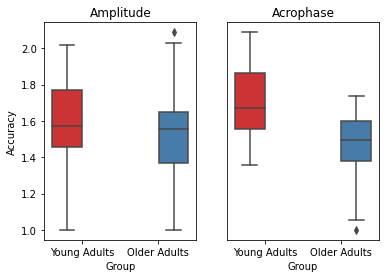

In [21]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='actamp', hue='Group', ax=axes[0]).set(title='Amplitude');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='actphi', hue='Group', ax=axes[1]).set(title='Acrophase');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rar.png', dpi=300)

In [22]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
actamp,1.534,1.603
actphi,14.709,16.427
sleep_time_mean_sleep,396.491,383.797
total_ac_mean_active,259869.089,317013.306
efficiency_mean_sleep,79.169,81.478


In [23]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').std().T

Group,Older Adults,Young Adults
actamp,0.256,0.222
actphi,1.323,1.457
sleep_time_mean_sleep,84.983,60.188
total_ac_mean_active,92862.754,181516.610
efficiency_mean_sleep,9.418,6.474


In [24]:
var='actamp'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=1.3908028637476353, pvalue=0.1676768595336022)

In [25]:
var='actphi'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=5.9662051375743435, pvalue=4.473568249689312e-08)

In [26]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_time_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['sleep_time_mean_sleep'].dropna())


Ttest_indResult(statistic=-0.8410444459933893, pvalue=0.40250373455001)

In [27]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['total_ac_mean_active'].dropna(), df[df['Group'] == "Older Adults"]['total_ac_mean_active'].dropna())



Ttest_indResult(statistic=1.895715645515264, pvalue=0.06113666161655153)

In [28]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['efficiency_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['efficiency_mean_sleep'].dropna())

Ttest_indResult(statistic=1.3948251317631477, pvalue=0.16642718062415893)

## Global brain network metrics <a id='graph'></a>

In [29]:
df[['q_dmnfpn_cue', 'q_dmnfpn_rest', 'pc_dmnfpn_cue', 'q_global_cue', 'q_global_rest', 'pc_global_cue', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
q_dmnfpn_cue,0.141,0.145
q_dmnfpn_rest,0.144,0.120
pc_dmnfpn_cue,0.214,0.185
q_global_cue,0.309,0.363
q_global_rest,0.369,0.371
pc_global_cue,0.425,0.413


In [30]:
df[['Group'] + fcVars].groupby('Group').mean().T

Group,Older Adults,Young Adults
hc_dmn_fc,0.231,0.197
hc_fpn_fc,0.170,0.089
dmn_fpn_fc,0.277,0.223
dmn_fc,0.361,0.341
fpn_fc,0.464,0.431


In [31]:
var = 'hc_dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.0245327619487798, pvalue=0.30911128762555895)

In [32]:
var = 'hc_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.2896384448885088, pvalue=0.025061171235776614)

In [33]:
var = 'dmn_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.6895183711116726, pvalue=0.09556972981081838)

In [34]:
var = 'dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-0.735584798222249, pvalue=0.4644410401138409)

In [35]:
var = 'fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.0711963850796413, pvalue=0.2877606209651291)

In [36]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.7968012843495549, pvalue=0.07708599285099443)

In [37]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.3498538415104826, pvalue=0.021605801580864482)

In [38]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.219598288755933, pvalue=7.217849241884767e-05)

In [39]:
dfl = df.reset_index()[['subject', 'Group'] + modVars]
dfl = pd.wide_to_long(dfl, ["q_global", 'q_power', "q_dmnfpn"], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,q_global,q_power,q_dmnfpn
0,30004,Young Adults,cue,0.398,0.398,0.242
1,30004,Young Adults,diff,0.015,NaN,-0.054
2,30004,Young Adults,match,0.382,0.382,0.158
3,30004,Young Adults,mismatch,0.301,0.301,0.179
4,30004,Young Adults,rest,0.413,NaN,0.188
...,...,...,...,...,...,...
480,40968,Older Adults,cue,0.346,0.346,0.207
481,40968,Older Adults,diff,NaN,NaN,NaN
482,40968,Older Adults,match,0.256,0.256,0.073
483,40968,Older Adults,mismatch,0.326,0.326,0.101


Text(0.5, 0, 'Condition')

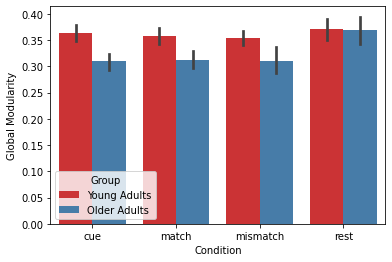

In [40]:
dfp = dfl[dfl['condition'] != 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

Text(0.5, 0, 'Condition')

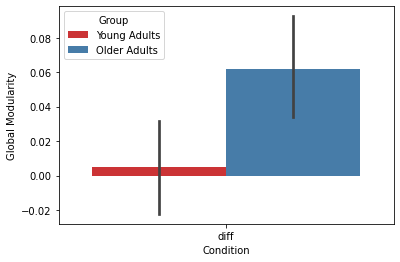

In [41]:
dfp = dfl[dfl['condition'] == 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

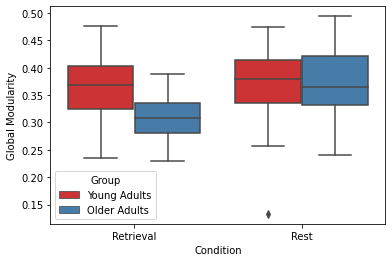

In [42]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.savefig('./results/globalmod_cond.png', dpi=300)

Text(0.5, 0, 'Condition')

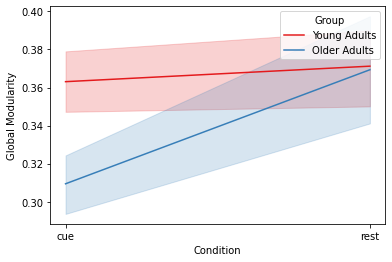

In [43]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

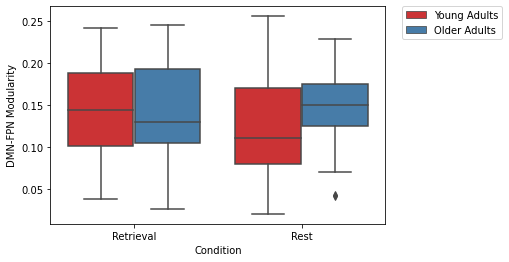

In [44]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('./results/dmnfpnmod_cond.png', dpi=300)

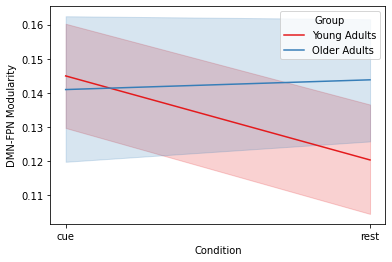

In [45]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition');

DMN-FPN Modularity

In [46]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.7968012843495549, pvalue=0.07708599285099443)

In [47]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.1453904094317924, pvalue=0.034808378646257215)

Global modularity

In [48]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.30207911067133786, pvalue=0.7635004205515875)

In [49]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), df[df['Group'] == "Young Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=0.6230621477974644, pvalue=0.5349118841388683)

In [50]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_global_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=3.798292862000818, pvalue=0.0004026572528685715)

In [51]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.19649364919748372, pvalue=0.845036508294355)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


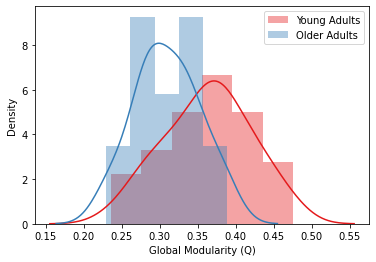

In [52]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig('./results/global_modularity.png', dpi=300)

In [53]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.219598288755933, pvalue=7.217849241884767e-05)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


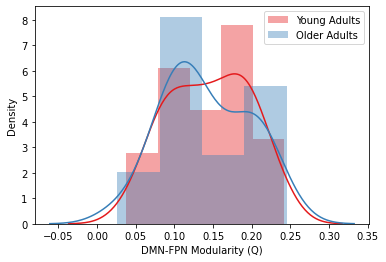

In [54]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna(), label = 'Older Adults')
plt.xlabel('DMN-FPN Modularity (Q)')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


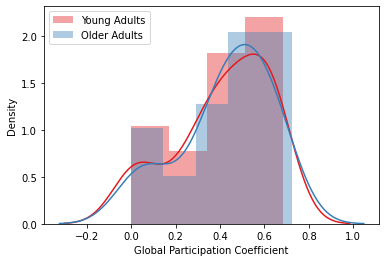

In [55]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig('./results/global_pc.png', dpi=300)

In [56]:
dfl = df.reset_index()[['subject', 'Group'] + pcVars[2:]]
dfl = pd.wide_to_long(dfl, ['pc_global', 'pc_dmn', 'pc_fpn', 'pc_dmnfpn'], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,pc_power_mismatch,pc_power_match,pc_power_cue,pc_global,pc_dmn,pc_fpn,pc_dmnfpn
0,30004,Young Adults,cue,0.281,0.572,0.421,NaN,0.439,0.293,0.132
1,30004,Young Adults,match,0.281,0.572,0.421,NaN,0.414,0.413,0.185
2,30004,Young Adults,mismatch,0.281,0.572,0.421,0.281,0.161,0.358,0.191
3,30008,Young Adults,cue,0.636,0.069,0.670,NaN,0.432,0.289,0.152
4,30008,Young Adults,match,0.636,0.069,0.670,NaN,0.333,0.447,0.182
...,...,...,...,...,...,...,...,...,...,...
286,40878,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,40878,Older Adults,mismatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,40968,Older Adults,cue,0.635,0.663,0.536,NaN,0.445,0.452,0.167
289,40968,Older Adults,match,0.635,0.663,0.536,NaN,0.511,0.551,0.275


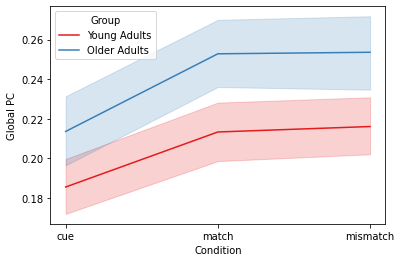

In [57]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('Global PC'); plt.xlabel('Condition');

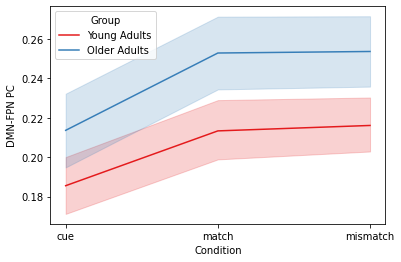

In [58]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('DMN-FPN PC'); plt.xlabel('Condition');

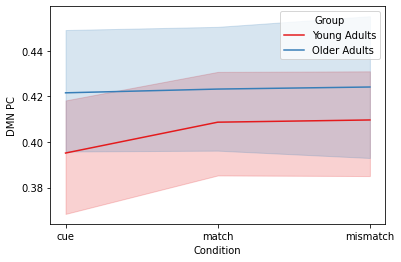

In [59]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmn'], hue=dfl['Group'])
plt.ylabel('DMN PC'); plt.xlabel('Condition');

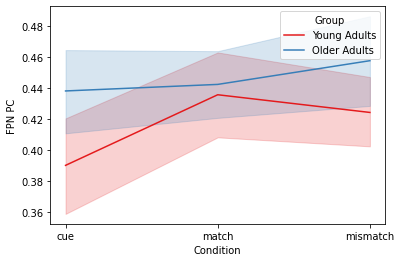

In [60]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_fpn'], hue=dfl['Group'])
plt.ylabel('FPN PC'); plt.xlabel('Condition');

## Mean FC <a id='fc'></a>

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


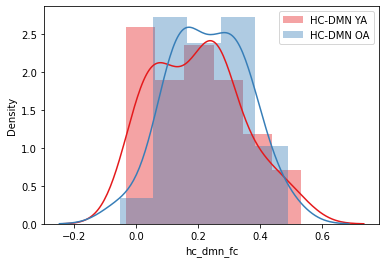

In [61]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


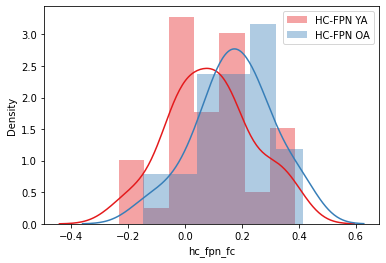

In [62]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [63]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'].dropna(), df[df['Group'] == "Older Adults"]['hc_fpn_fc'].dropna(), equal_var=True)

Ttest_indResult(statistic=-2.2896384448885088, pvalue=0.025061171235776614)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


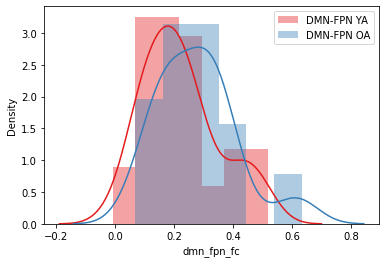

In [64]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

In [65]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


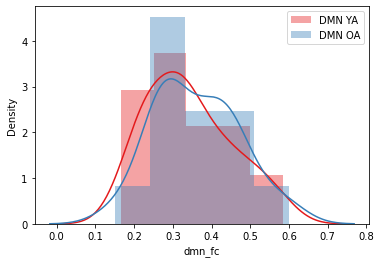

In [66]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


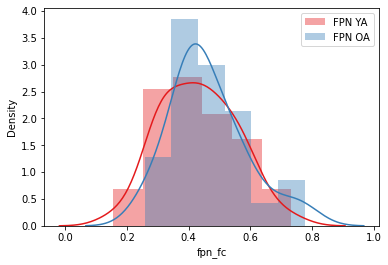

In [67]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()

## Regression analyses <a id='reg'></a>

In [68]:
from scipy.stats.mstats import zscore

convert_dict = {'Group': str,
                'sex': str
               }
  
df = df.astype(convert_dict)

print(df.shape)

(97, 94)


In [69]:
# ya = ya.select_dtypes(include=object).join(ya.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = ya.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# yaCl = ya[filtered_entries]
# yaCl.shape

In [70]:
# oa = oa.select_dtypes(include=object).join(oa.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = oa.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# oaCl = oa[filtered_entries]
# oaCl.shape

In [71]:
df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_48229/3237840119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()


age                                               hc_dmn_fc  \
             count    mean    std   min    25%   50%   75%   max     count   
Group                                                                        
Older Adults  47.0  67.532  5.081  60.0  64.00  67.0  71.0  81.0      27.0   
Young Adults  50.0  21.420  3.812  18.0  18.25  19.5  24.0  30.0      45.0   

                     ... hc_fpn_fc        q_global_cue                       \
               mean  ...       75%    max        count   mean    std    min   
Group                ...                                                      
Older Adults  0.231  ...     0.256  0.415         27.0  0.309  0.042  0.229   
Young Adults  0.197  ...     0.166  0.385         45.0  0.363  0.057  0.235   

                                          
                25%    50%    75%    max  
Group                                     
Older Adults  0.281  0.308  0.336  0.389  
Young Adults  0.324  0.368  0.402  0.476  

[2 rows x 32 columns]

## Hypotheses

In [72]:
smf.ols(formula='acc_mean_test_log ~ pc_dmnfpn_cue + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.496
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0146
Time:                        09:24:49   Log-Likelihood:                 117.22
No. Observations:                  72   AIC:                            -228.4
Df Residuals:                      69   BIC:                            -221.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1254      0.027     -4.661      0.000      -0.179      -0.072
Group[T.Young Adults]     0.0330      0.012      2.693      0.009       0.009       0.058
pc_dmnfpn_cue             0.2360      0.118      1.998      0.050       0.000       0.472
==============================================================================
Omnibus:                        6.289   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.424
Skew:                          -0.724   Prob(JB):                       0.0403
Kurtosis:                       2.786   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
regVars = ['rt_c_mean_test', 'q_dmnfpn_diff']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf.head())
smf.ols(formula='rt_c_mean_test ~ q_dmnfpn_diff', data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

                Group     sex  rt_c_mean_test  q_dmnfpn_diff
subject                                                     
30004    Young Adults  Female          -1.249         -0.598
30008    Young Adults  Female          -0.446         -1.272
30009    Young Adults  Female          -0.910          0.878
30015    Young Adults    Male           0.162         -0.045
30019    Young Adults  Female          -0.463         -0.311


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.098
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0923
Time:                        09:24:49   Log-Likelihood:                -29.450
No. Observations:                  24   AIC:                             62.90
Df Residuals:                      22   BIC:                             65.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8388      0.181      4.640      0.000       0.464       1.214
q_dmnfpn_diff    -0.3190      0.181     -1.760      0.092      -0.695       0.057
==============================================================================
Omnibus:                        0.332   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.011
Skew:                           0.052   Prob(JB):                        0.995
Kurtosis:                       3.000   Cond. No.                         1.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
regVars = ['acc_mean_test_log', 'pc_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf.head())
smf.ols(formula='acc_mean_test_log ~ pc_dmnfpn_cue', data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

                Group     sex  acc_mean_test_log  pc_dmnfpn_cue
subject                                                        
30004    Young Adults  Female              0.915         -1.265
30008    Young Adults  Female              0.666         -0.869
30009    Young Adults  Female              0.915         -1.071
30015    Young Adults    Male              0.145         -0.458
30019    Young Adults  Female              0.666          0.947


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     4.922
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0358
Time:                        09:24:49   Log-Likelihood:                -31.861
No. Observations:                  27   AIC:                             67.72
Df Residuals:                      25   BIC:                             70.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4529      0.167     -2.705      0.012      -0.798      -0.108
pc_dmnfpn_cue     0.3611      0.163      2.219      0.036       0.026       0.696
==============================================================================
Omnibus:                        0.216   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.009
Skew:                          -0.033   Prob(JB):                        0.996
Kurtosis:                       2.941   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
df[['dmn_fpn_fc', 'pc_dmnfpn_cue', 'q_dmnfpn_cue']].corr()

,dmn_fpn_fc,pc_dmnfpn_cue,q_dmnfpn_cue
dmn_fpn_fc,1.000,0.315,-0.374
pc_dmnfpn_cue,0.315,1.000,-0.672
q_dmnfpn_cue,-0.374,-0.672,1.000


In [76]:
regVars = ['acc_mean_test_log', 'dmn_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf.head())
smf.ols(formula='acc_mean_test_log ~ dmn_fpn_fc', data=regdf[regdf['Group'] == 'Young Adults']).fit().summary()

                Group     sex  acc_mean_test_log  dmn_fpn_fc
subject                                                     
30004    Young Adults  Female              0.915      -0.534
30008    Young Adults  Female              0.666       0.242
30009    Young Adults  Female              0.915      -1.089
30015    Young Adults    Male              0.145      -1.242
30019    Young Adults  Female              0.666      -0.427


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.305
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0262
Time:                        09:24:49   Log-Likelihood:                -62.378
No. Observations:                  45   AIC:                             128.8
Df Residuals:                      43   BIC:                             132.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1423      0.149      0.952      0.346      -0.159       0.444
dmn_fpn_fc    -0.3511      0.152     -2.303      0.026      -0.659      -0.044
==============================================================================
Omnibus:                       14.228   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.264
Skew:                          -1.335   Prob(JB):                     0.000485
Kurtosis:                       4.006   Cond. No.                         1.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
regVars = ['acc_mean_test_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf.head())
smf.ols(formula='acc_mean_test_log ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()

                Group     sex  acc_mean_test_log  q_dmnfpn_cue
subject                                                       
30004    Young Adults  Female              0.927         1.843
30008    Young Adults  Female              0.678         0.524
30009    Young Adults  Female              0.927         1.375
30015    Young Adults    Male              0.157         1.096
30019    Young Adults  Female              0.678        -0.078


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.362
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.102
Time:                        09:24:49   Log-Likelihood:                -98.360
No. Observations:                  71   AIC:                             202.7
Df Residuals:                      68   BIC:                             209.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3168      0.190     -1.665      0.100      -0.696       0.063
Group[T.Young Adults]     0.5112      0.242      2.115      0.038       0.029       0.993
q_dmnfpn_cue             -0.0679      0.117     -0.579      0.565      -0.302       0.166
==============================================================================
Omnibus:                        8.393   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.839
Skew:                          -0.863   Prob(JB):                       0.0120
Kurtosis:                       2.913   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
regVars = ['rt_c_mean_test', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf.head())
smf.ols(formula='rt_c_mean_test ~ q_dmnfpn_cue * Group', data=regdf).fit().summary()

                Group     sex  rt_c_mean_test  q_dmnfpn_cue
subject                                                    
30004    Young Adults  Female          -1.161         1.843
30008    Young Adults  Female          -0.371         0.524
30009    Young Adults  Female          -0.827         1.375
30015    Young Adults    Male           0.227         1.096
30019    Young Adults  Female          -0.387        -0.078


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     10.59
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           8.68e-06
Time:                        09:24:49   Log-Likelihood:                -86.964
No. Observations:                  71   AIC:                             181.9
Df Residuals:                      67   BIC:                             191.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.7131      0.163      4.366      0.000       0.387       1.039
Group[T.Young Adults]                 -1.1439      0.207     -5.515      0.000      -1.558      -0.730
q_dmnfpn_cue                           0.2066      0.158      1.304      0.197      -0.110       0.523
q_dmnfpn_cue:Group[T.Young Adults]    -0.2419      0.205     -1.179      0.243      -0.651       0.168
==============================================================================
Omnibus:                        0.387   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.069
Skew:                          -0.039   Prob(JB):                        0.966
Kurtosis:                       3.130   Cond. No.                         3.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
smf.ols(formula='acc_mean_test ~ pc_dmnfpn_cue + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_mean_test   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.690
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0123
Time:                        09:24:49   Log-Likelihood:                 69.569
No. Observations:                  72   AIC:                            -133.1
Df Residuals:                      69   BIC:                            -126.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7518      0.052     14.418      0.000       0.648       0.856
Group[T.Young Adults]     0.0670      0.024      2.816      0.006       0.020       0.114
pc_dmnfpn_cue             0.4397      0.229      1.920      0.059      -0.017       0.896
==============================================================================
Omnibus:                        4.848   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.791
Skew:                          -0.593   Prob(JB):                       0.0911
Kurtosis:                       2.561   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
regVars = ['acc_mean_test_log', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.138
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0309
Time:                        09:24:49   Log-Likelihood:                -97.496
No. Observations:                  72   AIC:                             203.0
Df Residuals:                      68   BIC:                             212.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4324      0.198     -2.181      0.033      -0.828      -0.037
Group[T.Young Adults]               0.5852      0.247      2.373      0.020       0.093       1.077
hc_fpn_fc                           0.3098      0.204      1.516      0.134      -0.098       0.718
hc_fpn_fc:Group[T.Young Adults]    -0.5214      0.250     -2.085      0.041      -1.020      -0.022
==============================================================================
Omnibus:                       10.174   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.731
Skew:                          -0.942   Prob(JB):                      0.00467
Kurtosis:                       3.160   Cond. No.                         3.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Brain - Memory Associations

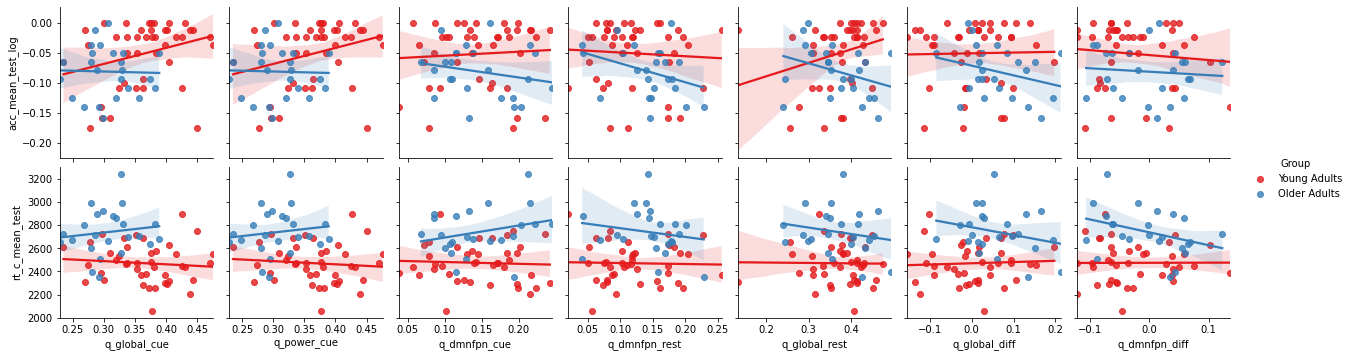

In [81]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if 'cue' in v or 'rest' in v or 'diff' in v]
sns.pairplot(data=df[df['q_global_rest'].abs() < 3], y_vars=['acc_mean_test_log', 'rt_c_mean_test'], x_vars=modVars_, hue='Group', kind='reg')

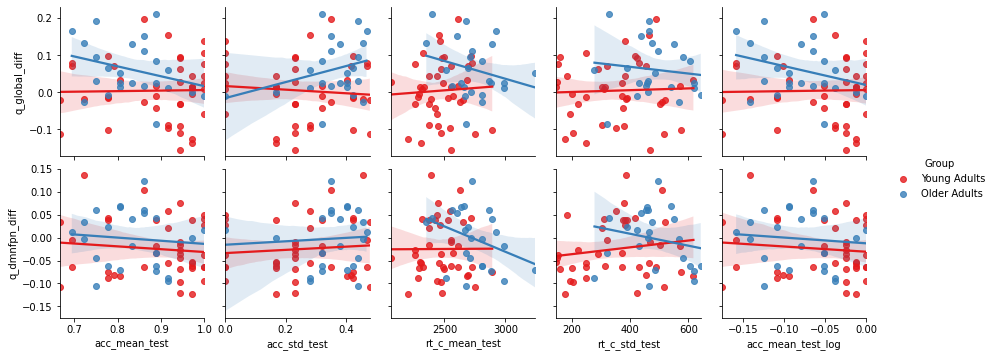

In [82]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if 'diff' in v]
memVars_ = [v for v in memVars if 'test' in v]
sns.pairplot(data=df, x_vars=memVars_, y_vars=modVars_, hue='Group', kind='reg')

In [83]:
smf.ols(formula='acc_mean_test_log ~ q_global_cue', data=df[df['Group'] == 'Young Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.337
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.134
Time:                        09:25:02   Log-Likelihood:                 70.555
No. Observations:                  45   AIC:                            -137.1
Df Residuals:                      43   BIC:                            -133.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1240      0.050     -2.483      0.017      -0.225      -0.023
q_global_cue     0.2078      0.136      1.529      0.134      -0.066       0.482
==============================================================================
Omnibus:                        9.377   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.220
Skew:                          -1.098   Prob(JB):                      0.00995
Kurtosis:                       3.303   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
smf.ols(formula='rt_c_mean_test ~ q_dmnfpn_diff', data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.098
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0923
Time:                        09:25:02   Log-Likelihood:                -158.79
No. Observations:                  24   AIC:                             321.6
Df Residuals:                      22   BIC:                             323.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2738.3150     38.574     70.989      0.000    2658.318    2818.312
q_dmnfpn_diff -1115.7600    633.920     -1.760      0.092   -2430.430     198.910
==============================================================================
Omnibus:                        0.332   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.011
Skew:                           0.052   Prob(JB):                        0.995
Kurtosis:                       3.000   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
smf.ols(formula='acc_mean_test_log ~ q_global_rest * Group', data=df[df['q_global_rest'] > 0.2]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     5.927
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00129
Time:                        09:25:02   Log-Likelihood:                 109.63
No. Observations:                  65   AIC:                            -211.3
Df Residuals:                      61   BIC:                            -202.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0073      0.053     -0.139      0.890      -0.113       0.098
Group[T.Young Adults]                  -0.2045      0.074     -2.752      0.008      -0.353      -0.056
q_global_rest                          -0.2014      0.141     -1.432      0.157      -0.483       0.080
q_global_rest:Group[T.Young Adults]     0.6252      0.197      3.180      0.002       0.232       1.018
==============================================================================
Omnibus:                        5.402   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.397
Skew:                          -0.696   Prob(JB):                       0.0673
Kurtosis:                       2.764   Cond. No.                         54.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

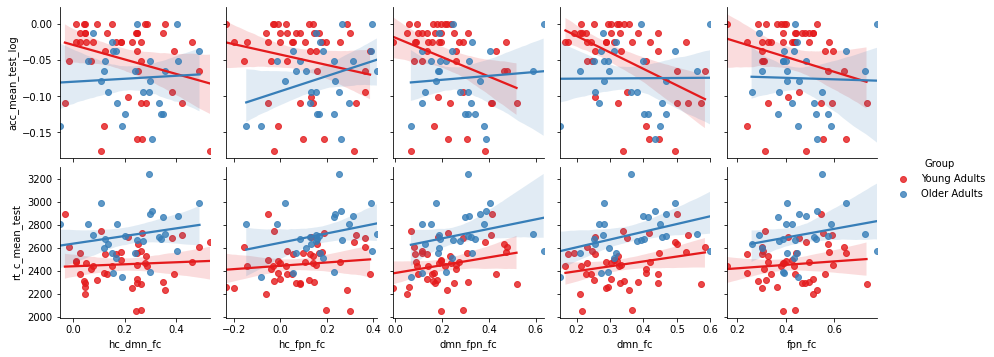

In [86]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_mean_test_log', 'rt_c_mean_test'], x_vars=fcVars, hue='Group', kind='reg')

In [87]:
smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.138
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0309
Time:                        09:25:11   Log-Likelihood:                 117.48
No. Observations:                  72   AIC:                            -227.0
Df Residuals:                      68   BIC:                            -217.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0929      0.015     -6.155      0.000      -0.123      -0.063
Group[T.Young Adults]               0.0508      0.017      2.933      0.005       0.016       0.085
hc_fpn_fc                           0.1053      0.069      1.516      0.134      -0.033       0.244
hc_fpn_fc:Group[T.Young Adults]    -0.1772      0.085     -2.085      0.041      -0.347      -0.008
==============================================================================
Omnibus:                       10.174   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.731
Skew:                          -0.942   Prob(JB):                      0.00467
Kurtosis:                       3.160   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
smf.ols(formula='acc_mean_test_log ~ dmn_fc * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     6.231
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           0.000841
Time:                        09:25:11   Log-Likelihood:                 121.55
No. Observations:                  72   AIC:                            -235.1
Df Residuals:                      68   BIC:                            -226.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0761      0.031     -2.429      0.018      -0.139      -0.014
Group[T.Young Adults]            0.1054      0.039      2.730      0.008       0.028       0.182
dmn_fc                           0.0031      0.083      0.037      0.971      -0.163       0.169
dmn_fc:Group[T.Young Adults]    -0.2311      0.104     -2.215      0.030      -0.439      -0.023
==============================================================================
Omnibus:                        5.646   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                5.578
Skew:                          -0.679   Prob(JB):                       0.0615
Kurtosis:                       2.885   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
smf.ols(formula='rt_c_mean_test ~ dmn_fc + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     20.38
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.11e-07
Time:                        09:25:11   Log-Likelihood:                -474.71
No. Observations:                  72   AIC:                             955.4
Df Residuals:                      69   BIC:                             962.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2528.5396     79.086     31.972      0.000    2370.767    2686.312
Group[T.Young Adults]  -245.7202     44.098     -5.572      0.000    -333.692    -157.748
dmn_fc                  515.1739    196.808      2.618      0.011     122.552     907.796
==============================================================================
Omnibus:                        0.679   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.373
Skew:                           0.171   Prob(JB):                        0.830
Kurtosis:                       3.082   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

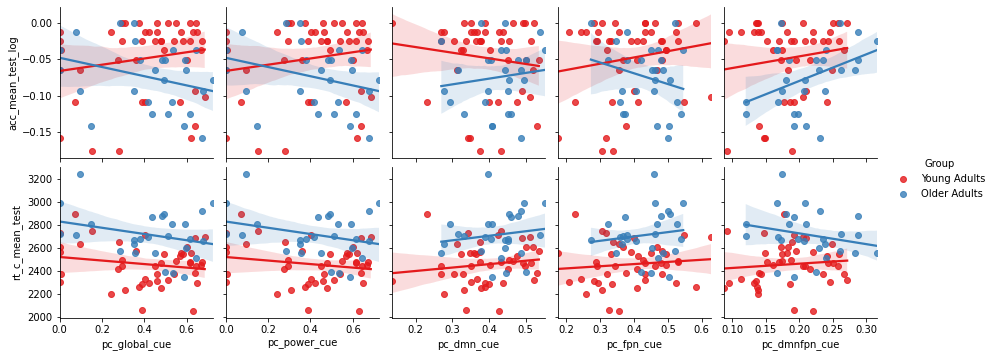

In [90]:
sns.set_palette('Set1')
pcVars_ = [v for v in pcVars if 'cue' in v or 'rest' in v]
sns.pairplot(data=df, y_vars=['acc_mean_test_log', 'rt_c_mean_test'], x_vars=pcVars_, hue='Group', kind='reg')

In [91]:
smf.ols(formula='acc_mean_test ~ pc_dmnfpn_cue + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_mean_test   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.690
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0123
Time:                        09:25:19   Log-Likelihood:                 69.569
No. Observations:                  72   AIC:                            -133.1
Df Residuals:                      69   BIC:                            -126.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7518      0.052     14.418      0.000       0.648       0.856
Group[T.Young Adults]     0.0670      0.024      2.816      0.006       0.020       0.114
pc_dmnfpn_cue             0.4397      0.229      1.920      0.059      -0.017       0.896
==============================================================================
Omnibus:                        4.848   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.791
Skew:                          -0.593   Prob(JB):                       0.0911
Kurtosis:                       2.561   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
smf.ols(formula='acc_mean_test ~ pc_dmnfpn_cue', data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_mean_test   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4.991
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0347
Time:                        09:25:19   Log-Likelihood:                 30.927
No. Observations:                  27   AIC:                            -57.85
Df Residuals:                      25   BIC:                            -55.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6947      0.069     10.026      0.000       0.552       0.837
pc_dmnfpn_cue     0.7067      0.316      2.234      0.035       0.055       1.358
==============================================================================
Omnibus:                        0.396   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.131
Skew:                           0.169   Prob(JB):                        0.936
Kurtosis:                       2.948   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

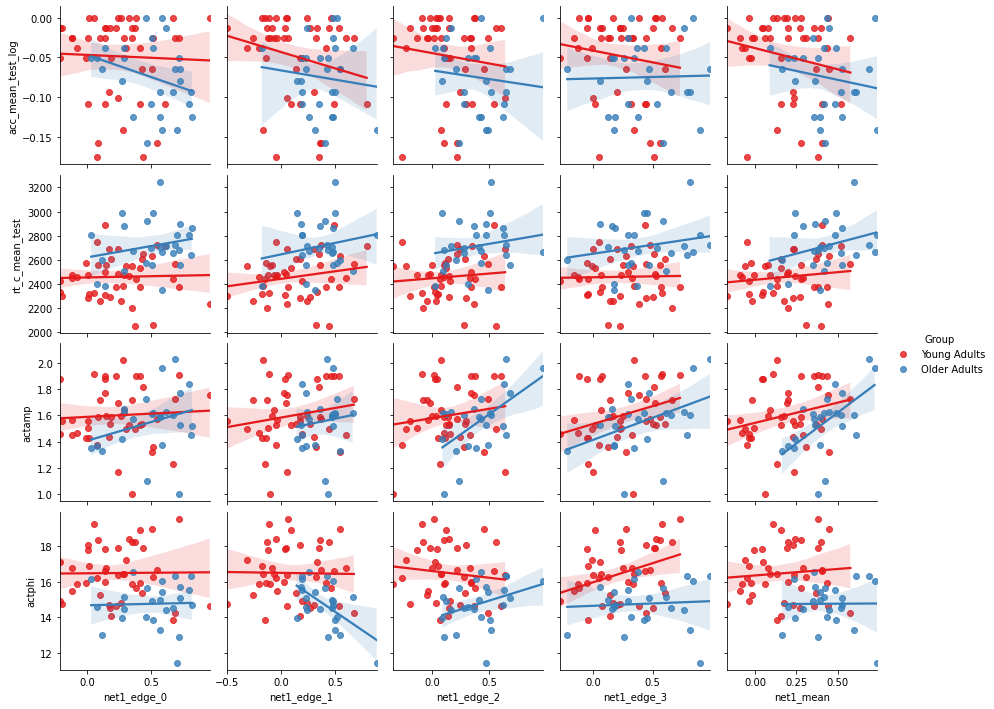

In [93]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_mean_test_log', 'rt_c_mean_test', 'actamp', 'actphi'], x_vars=[v for v in edgeVars if 'net1' in v], hue='Group', kind='reg')

In [94]:
regVars = ['net1_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='net1_mean ~ actamp + Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     22.46
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           3.85e-08
Time:                        09:25:29   Log-Likelihood:                -78.626
No. Observations:                  68   AIC:                             163.3
Df Residuals:                      65   BIC:                             169.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8127      0.161      5.045      0.000       0.491       1.134
Group[T.Young Adults]    -1.2560      0.201     -6.261      0.000      -1.657      -0.855
actamp                    0.2889      0.096      3.013      0.004       0.097       0.480
==============================================================================
Omnibus:                        2.643   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                1.567
Skew:                           0.018   Prob(JB):                        0.457
Kurtosis:                       2.257   Cond. No.                         3.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
regVars = ['net1_mean', 'actamp', 'total_ac_mean_active']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='net1_mean ~ actamp + total_ac_mean_active + Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     14.76
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           2.07e-07
Time:                        09:25:30   Log-Likelihood:                -78.608
No. Observations:                  68   AIC:                             165.2
Df Residuals:                      64   BIC:                             174.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8092      0.163      4.951      0.000       0.483       1.136
Group[T.Young Adults]    -1.2505      0.204     -6.121      0.000      -1.659      -0.842
actamp                    0.2957      0.103      2.859      0.006       0.089       0.502
total_ac_mean_active     -0.0192      0.104     -0.184      0.855      -0.228       0.189
==============================================================================
Omnibus:                        2.449   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                1.502
Skew:                           0.015   Prob(JB):                        0.472
Kurtosis:                       2.273   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

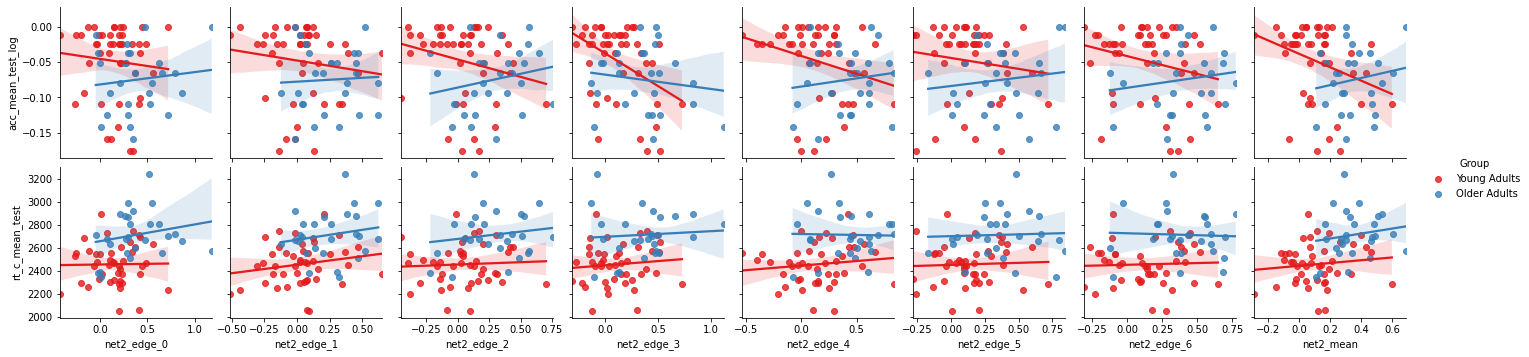

In [96]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_mean_test_log', 'rt_c_mean_test'], x_vars=[v for v in edgeVars if 'net2' in v], hue='Group', kind='reg')

In [97]:
smf.ols(formula='acc_mean_test_log ~ net2_mean * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.535
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0192
Time:                        09:25:38   Log-Likelihood:                 118.03
No. Observations:                  72   AIC:                            -228.1
Df Residuals:                      68   BIC:                            -219.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0926      0.025     -3.731      0.000      -0.142      -0.043
Group[T.Young Adults]               0.0544      0.026      2.071      0.042       0.002       0.107
net2_mean                           0.0502      0.066      0.766      0.447      -0.081       0.181
net2_mean:Group[T.Young Adults]    -0.1453      0.078     -1.858      0.068      -0.301       0.011
==============================================================================
Omnibus:                        9.824   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.145
Skew:                          -0.913   Prob(JB):                      0.00627
Kurtosis:                       3.217   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## RAR - Brain Associations

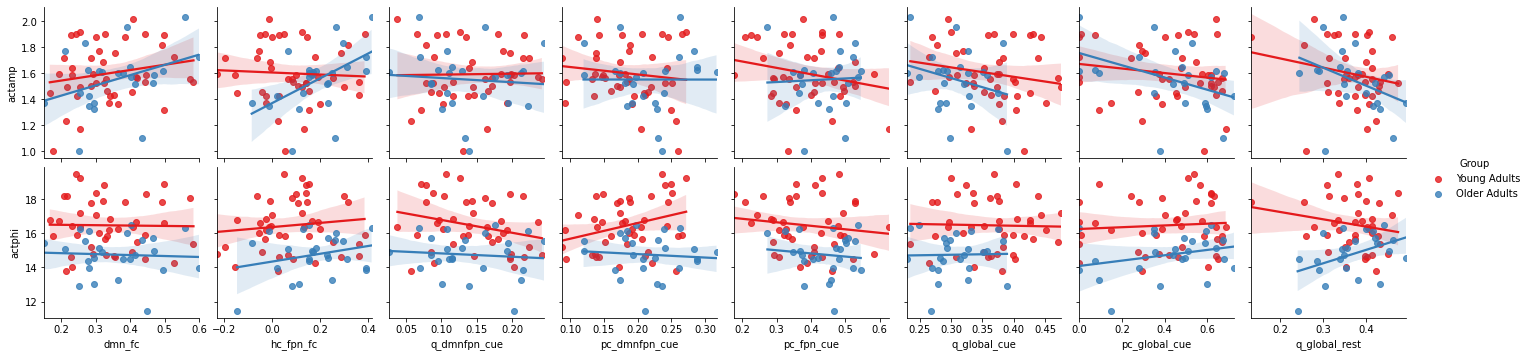

In [98]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['actamp', 'actphi'],
             x_vars=['dmn_fc', 'hc_fpn_fc', 'q_dmnfpn_cue', 'pc_dmnfpn_cue', 'pc_fpn_cue', 'q_global_cue', 'pc_global_cue', 'q_global_rest'], hue='Group', kind='reg')

In [99]:
regVars = ['dmn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='dmn_fc ~ actamp + Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dmn_fc   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.637
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0792
Time:                        09:25:45   Log-Likelihood:                -93.835
No. Observations:                  68   AIC:                             193.7
Df Residuals:                      65   BIC:                             200.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1568      0.201      0.779      0.439      -0.246       0.559
Group[T.Young Adults]    -0.2424      0.251     -0.966      0.338      -0.743       0.259
actamp                    0.2603      0.120      2.171      0.034       0.021       0.500
==============================================================================
Omnibus:                        3.048   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.989
Skew:                           0.477   Prob(JB):                        0.224
Kurtosis:                       2.620   Cond. No.                         3.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
regVars = ['dmn_fc', 'actamp', 'total_ac_mean_active']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='dmn_fc ~ actamp + total_ac_mean_active + Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dmn_fc   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.807
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.155
Time:                        09:25:46   Log-Likelihood:                -93.724
No. Observations:                  68   AIC:                             195.4
Df Residuals:                      64   BIC:                             204.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1458      0.204      0.714      0.478      -0.262       0.554
Group[T.Young Adults]    -0.2254      0.255     -0.883      0.380      -0.735       0.284
actamp                    0.2814      0.129      2.178      0.033       0.023       0.539
total_ac_mean_active     -0.0597      0.130     -0.458      0.649      -0.320       0.201
==============================================================================
Omnibus:                        3.100   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                3.019
Skew:                           0.470   Prob(JB):                        0.221
Kurtosis:                       2.574   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp * Group', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.848
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00421
Time:                        09:25:46   Log-Likelihood:                -89.525
No. Observations:                  68   AIC:                             187.0
Df Residuals:                      64   BIC:                             195.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.5241      0.192      2.735      0.008       0.141       0.907
Group[T.Young Adults]           -0.7750      0.238     -3.261      0.002      -1.250      -0.300
actamp                           0.4145      0.184      2.248      0.028       0.046       0.783
actamp:Group[T.Young Adults]    -0.4674      0.234     -1.999      0.050      -0.935      -0.000
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.098
Skew:                           0.085   Prob(JB):                        0.952
Kurtosis:                       2.924   Cond. No.                         3.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp', data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.681
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0111
Time:                        09:25:46   Log-Likelihood:                -26.256
No. Observations:                  24   AIC:                             56.51
Df Residuals:                      22   BIC:                             58.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5241      0.155      3.372      0.003       0.202       0.846
actamp         0.4145      0.150      2.771      0.011       0.104       0.725
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.231
Skew:                          -0.148   Prob(JB):                        0.891
Kurtosis:                       2.621   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
regVars = ['hc_fpn_fc', 'actamp', 'total_ac_mean_active']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp + total_ac_mean_active', data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     3.835
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0380
Time:                        09:25:46   Log-Likelihood:                -26.113
No. Observations:                  24   AIC:                             58.23
Df Residuals:                      21   BIC:                             61.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4912      0.171      2.869      0.009       0.135       0.847
actamp                   0.5046      0.236      2.141      0.044       0.014       0.995
total_ac_mean_active    -0.1941      0.388     -0.501      0.622      -1.000       0.612
==============================================================================
Omnibus:                        0.164   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.377
Skew:                          -0.062   Prob(JB):                        0.828
Kurtosis:                       2.399   Cond. No.                         3.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp', data=regdf[regdf['Group'] == 'Young Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.1149
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.736
Time:                        09:25:46   Log-Likelihood:                -61.865
No. Observations:                  44   AIC:                             127.7
Df Residuals:                      42   BIC:                             131.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2509      0.153     -1.643      0.108      -0.559       0.057
actamp        -0.0530      0.156     -0.339      0.736      -0.368       0.262
==============================================================================
Omnibus:                        0.162   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.244
Skew:                           0.132   Prob(JB):                        0.885
Kurtosis:                       2.749   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
smf.ols(formula='q_global_rest ~ actamp + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.248
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.114
Time:                        09:25:46   Log-Likelihood:                 86.391
No. Observations:                  63   AIC:                            -166.8
Df Residuals:                      60   BIC:                            -160.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4859      0.055      8.833      0.000       0.376       0.596
Group[T.Young Adults]    -0.0004      0.017     -0.021      0.983      -0.034       0.033
actamp                   -0.0728      0.035     -2.105      0.040      -0.142      -0.004
==============================================================================
Omnibus:                       12.204   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.273
Skew:                          -0.890   Prob(JB):                      0.00131
Kurtosis:                       4.374   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
smf.ols(formula='dmn_fc ~ actamp', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dmn_fc   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.346
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0410
Time:                        09:25:46   Log-Likelihood:                 57.411
No. Observations:                  68   AIC:                            -110.8
Df Residuals:                      66   BIC:                            -106.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1560      0.091      1.712      0.092      -0.026       0.338
actamp         0.1188      0.057      2.085      0.041       0.005       0.233
==============================================================================
Omnibus:                        3.139   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                3.023
Skew:                           0.462   Prob(JB):                        0.221
Kurtosis:                       2.538   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
smf.ols(formula='q_global_cue ~ actamp + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           q_global_cue   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     10.00
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           0.000163
Time:                        09:25:46   Log-Likelihood:                 105.50
No. Observations:                  68   AIC:                            -205.0
Df Residuals:                      65   BIC:                            -198.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3840      0.045      8.447      0.000       0.293       0.475
Group[T.Young Adults]     0.0573      0.013      4.283      0.000       0.031       0.084
actamp                   -0.0487      0.028     -1.712      0.092      -0.106       0.008
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.324
Skew:                           0.008   Prob(JB):                        0.850
Kurtosis:                       2.662   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
smf.ols(formula='hc_fpn_fc ~  actamp * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.848
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00421
Time:                        09:25:46   Log-Likelihood:                 40.788
No. Observations:                  68   AIC:                            -73.58
Df Residuals:                      64   BIC:                            -64.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.2311      0.190     -1.219      0.227      -0.610       0.148
Group[T.Young Adults]            0.3706      0.243      1.525      0.132      -0.115       0.856
actamp                           0.2714      0.121      2.248      0.028       0.030       0.513
actamp:Group[T.Young Adults]    -0.3060      0.153     -1.999      0.050      -0.612      -0.000
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.098
Skew:                           0.085   Prob(JB):                        0.952
Kurtosis:                       2.924   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
smf.ols(formula='hc_fpn_fc ~  actamp', data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.681
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0111
Time:                        09:25:46   Log-Likelihood:                 19.737
No. Observations:                  24   AIC:                            -35.47
Df Residuals:                      22   BIC:                            -33.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2311      0.154     -1.503      0.147      -0.550       0.088
actamp         0.2714      0.098      2.771      0.011       0.068       0.474
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.231
Skew:                          -0.148   Prob(JB):                        0.891
Kurtosis:                       2.621   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
smf.ols(formula='pc_dmnfpn_cue ~ actamp', data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_dmnfpn_cue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                 5.456e-06
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.998
Time:                        09:25:46   Log-Likelihood:                 37.966
No. Observations:                  24   AIC:                            -71.93
Df Residuals:                      22   BIC:                            -69.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2177      0.072      3.026      0.006       0.068       0.367
actamp        -0.0001      0.046     -0.002      0.998      -0.095       0.095
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   2.513
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.227
Skew:                          -0.029   Prob(JB):                        0.893
Kurtosis:                       2.527   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
smf.ols(formula='acc_mean_test_log ~ actamp', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.102
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0816
Time:                        09:25:46   Log-Likelihood:                 143.08
No. Observations:                  93   AIC:                            -282.2
Df Residuals:                      91   BIC:                            -277.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1232      0.036     -3.398      0.001      -0.195      -0.051
actamp         0.0402      0.023      1.761      0.082      -0.005       0.086
==============================================================================
Omnibus:                        9.135   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.387
Skew:                          -0.735   Prob(JB):                      0.00916
Kurtosis:                       2.490   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
smf.ols(formula='rt_c_mean_test ~ actamp + Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     28.07
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           3.35e-10
Time:                        09:25:46   Log-Likelihood:                -622.78
No. Observations:                  93   AIC:                             1252.
Df Residuals:                      90   BIC:                             1259.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2892.2771    137.509     21.033      0.000    2619.092    3165.462
Group[T.Young Adults]  -301.4547     41.798     -7.212      0.000    -384.493    -218.416
actamp                  -84.9174     87.462     -0.971      0.334    -258.675      88.840
==============================================================================
Omnibus:                        3.191   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.519
Skew:                           0.309   Prob(JB):                        0.284
Kurtosis:                       3.518   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
smf.ols(formula='acc_mean_test_log ~ actphi * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.339
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0228
Time:                        09:25:46   Log-Likelihood:                 147.34
No. Observations:                  94   AIC:                            -286.7
Df Residuals:                      90   BIC:                            -276.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0578      0.087     -0.666      0.507      -0.230       0.115
Group[T.Young Adults]            0.1037      0.121      0.857      0.394      -0.137       0.344
actphi                          -0.0013      0.006     -0.226      0.822      -0.013       0.010
actphi:Group[T.Young Adults]    -0.0043      0.008     -0.546      0.586      -0.020       0.011
==============================================================================
Omnibus:                        8.390   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                9.001
Skew:                          -0.748   Prob(JB):                       0.0111
Kurtosis:                       2.751   Cond. No.                         488.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
smf.ols(formula='rt_c_mean_test ~ actphi * Group', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     19.99
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           5.13e-10
Time:                        09:25:46   Log-Likelihood:                -628.10
No. Observations:                  94   AIC:                             1264.
Df Residuals:                      90   BIC:                             1274.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     3298.8866    331.999      9.936      0.000    2639.312    3958.461
Group[T.Young Adults]         -752.4976    462.668     -1.626      0.107   -1671.668     166.673
actphi                         -36.4364     22.483     -1.621      0.109     -81.102       8.229
actphi:Group[T.Young Adults]    30.8535     29.788      1.036      0.303     -28.326      90.033
==============================================================================
Omnibus:                        4.405   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.116
Skew:                           0.309   Prob(JB):                        0.128
Kurtosis:                       3.818   Cond. No.                         488.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc', data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.985
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0964
Time:                        09:25:47   Log-Likelihood:                 47.852
No. Observations:                  27   AIC:                            -91.70
Df Residuals:                      25   BIC:                            -89.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0929      0.013     -7.015      0.000      -0.120      -0.066
hc_fpn_fc      0.1053      0.061      1.728      0.096      -0.020       0.231
==============================================================================
Omnibus:                        1.159   Durbin-Watson:                   2.499
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                0.940
Skew:                          -0.194   Prob(JB):                        0.625
Kurtosis:                       2.172   Cond. No.                         7.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mediation

In [116]:
medtab = pg.mediation_analysis(data=df, x='actamp', 
                               m='dmn_fc', 
                               y='acc_mean_test_log', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,dmn_fc ~ X,0.124,0.057,0.034,0.010,0.239,Yes
1,Y ~ dmn_fc,-0.124,0.054,0.026,-0.232,-0.016,Yes
2,Total,0.031,0.027,0.254,-0.023,0.084,No
3,Direct,0.050,0.026,0.065,-0.003,0.102,No
4,Indirect,-0.019,0.011,0.060,-0.048,-0.001,No


In [117]:
medtab = pg.mediation_analysis(data=df, x='actamp', 
                               m='dmn_fc', 
                               y='rt_c_mean_test', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,dmn_fc ~ X,0.124,0.057,0.034,0.010,0.239,Yes
1,Y ~ dmn_fc,446.963,205.018,0.033,37.514,856.412,Yes
2,Total,-85.088,101.050,0.403,-286.898,116.722,No
3,Direct,-150.871,100.607,0.139,-351.857,50.115,No
4,Indirect,65.783,42.217,0.060,2.724,182.545,No


In [118]:
medtab = pg.mediation_analysis(data=df, x='actphi', 
                               m='pc_dmnfpn_cue', 
                               y='acc_mean_test_log', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,pc_dmnfpn_cue ~ X,0.006,0.004,0.143,-2.162e-03,0.015,No
1,Y ~ pc_dmnfpn_cue,0.246,0.120,0.044,6.907e-03,0.485,Yes
2,Total,-0.005,0.004,0.289,-1.307e-02,0.004,No
3,Direct,-0.006,0.004,0.138,-1.468e-02,0.002,No
4,Indirect,0.002,0.002,0.160,9.590e-06,0.008,No


In [119]:
medtab = pg.mediation_analysis(data=df, x='actamp', 
                               m='q_global_rest', 
                               y='rt_c_mean_test', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,q_global_rest ~ X,-0.073,0.035,0.040,-0.142,-0.004,Yes
1,Y ~ q_global_rest,-297.490,359.434,0.411,-1016.465,421.484,No
2,Total,-80.972,99.815,0.420,-280.631,118.688,No
3,Direct,-110.208,103.292,0.290,-316.895,96.480,No
4,Indirect,29.236,33.011,0.192,-8.321,117.688,No


In [120]:
medtab = pg.mediation_analysis(data=df[df['Group'] == 'Older Adults'], 
                               x='actamp', 
                               m='hc_fpn_fc', 
                               y='acc_mean_test_log',
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,hc_fpn_fc ~ X,0.271,0.098,0.011,0.068,0.474,Yes
1,Y ~ hc_fpn_fc,0.088,0.071,0.229,-0.060,0.237,No
2,Total,0.063,0.037,0.105,-0.014,0.140,No
3,Direct,0.052,0.044,0.248,-0.039,0.143,No
4,Indirect,0.011,0.032,0.612,-0.033,0.088,No


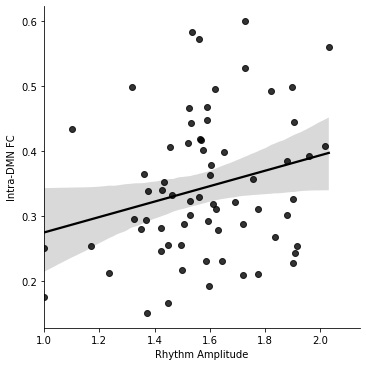

In [121]:
sns.lmplot(data=df, x='actamp', y='dmn_fc',
             scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Intra-DMN FC')
plt.savefig('./results/amp_dmnfc.png', dpi=300)

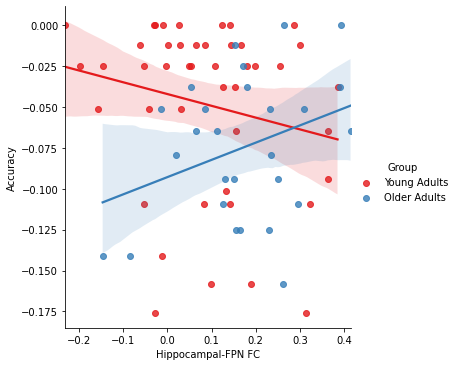

In [122]:
sns.lmplot(data=df, x='hc_fpn_fc', y='acc_mean_test_log', hue='Group')
plt.ylabel('Accuracy'); plt.xlabel('Hippocampal-FPN FC')
plt.savefig('./results/hcfpnfc_acc.png', dpi=300)

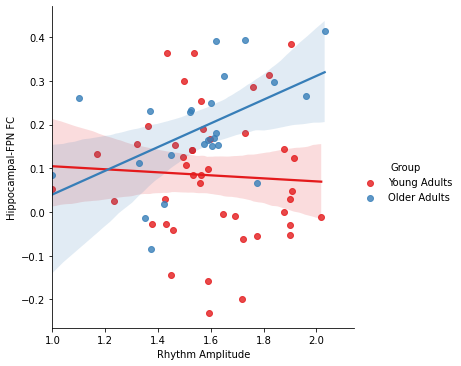

In [123]:
sns.lmplot(data=df, x='actamp', y='hc_fpn_fc', hue='Group')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc.png', dpi=300)

In [124]:
sns.color_palette('Set1')[1]

(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)

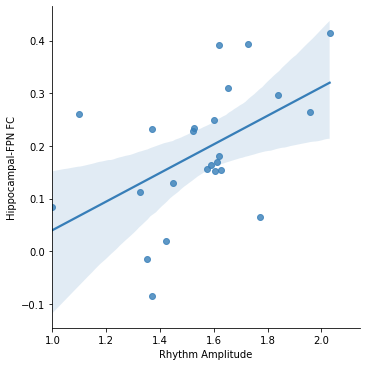

In [125]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='hc_fpn_fc', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc_oa.png', dpi=300)

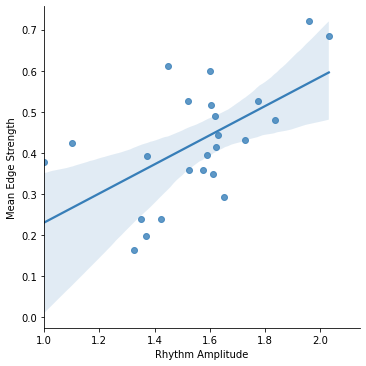

In [126]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='net1_mean', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.savefig('./results/amp_net1mean_oa.png', dpi=300)

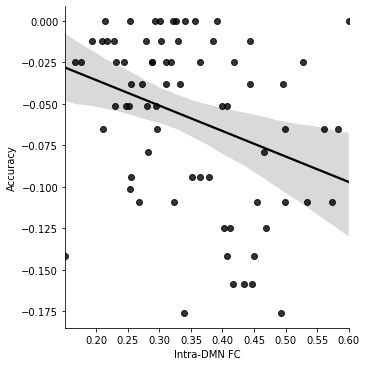

In [127]:
sns.lmplot(data=df, x='dmn_fc', y='acc_mean_test_log',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Intra-DMN FC'); plt.ylabel('Accuracy')
plt.savefig('./results/dmn_acc.png', dpi=300)

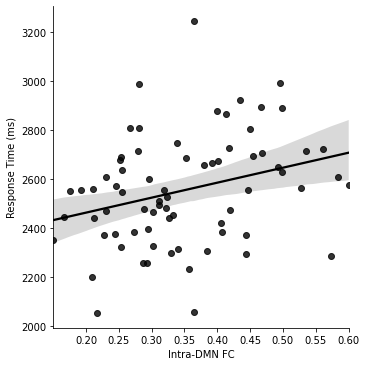

In [128]:
sns.lmplot(data=df, x='dmn_fc', y='rt_c_mean_test',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Intra-DMN FC'); plt.ylabel('Response Time (ms)')
plt.savefig('./results/dmn_rtc.png', dpi=300)

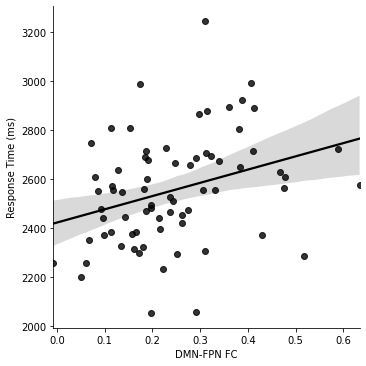

In [129]:
sns.lmplot(data=df, x='dmn_fpn_fc', y='rt_c_mean_test',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('DMN-FPN FC'); plt.ylabel('Response Time (ms)')
plt.savefig('./results/dmnfpn_rtc.png', dpi=300)

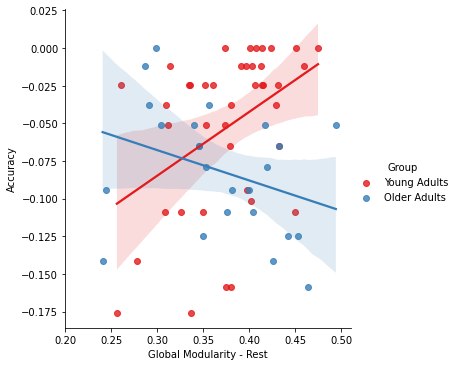

In [130]:
sns.lmplot(data=df[df['q_global_rest'] > 0.15], x='q_global_rest', y='acc_mean_test_log', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Global Modularity - Rest'); plt.ylabel('Accuracy'), plt.xlim([0.20, 0.51])
plt.savefig('./results/qglobalrest_acc.png', dpi=300)

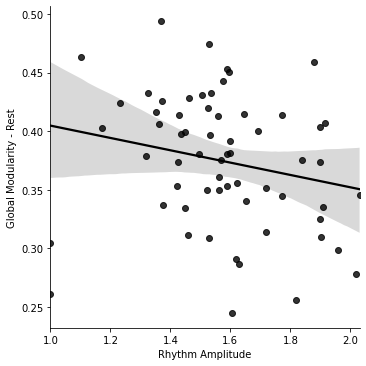

In [131]:
sns.lmplot(data=df[df['q_global_rest'] > 0.15], x='actamp', y='q_global_rest',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Global Modularity - Rest')
plt.savefig('./results/amp_qglobalrest.png', dpi=300)

In [132]:
regVars = ['q_global_rest', 'actamp']

regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.870
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0954
Time:                        09:25:58   Log-Likelihood:                -79.117
No. Observations:                  62   AIC:                             162.2
Df Residuals:                      60   BIC:                             166.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0562      0.112      0.502      0.617      -0.168       0.280
actamp        -0.1907      0.113     -1.694      0.095      -0.416       0.034
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.700
Skew:                          -0.398   Prob(JB):                        0.427
Kurtosis:                       2.843   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
regVars = ['hc_fpn_fc', 'acc_mean_test_log']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_mean_test_log ~ Group * hc_fpn_fc', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.138
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0309
Time:                        09:27:09   Log-Likelihood:                -97.496
No. Observations:                  72   AIC:                             203.0
Df Residuals:                      68   BIC:                             212.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4324      0.198     -2.181      0.033      -0.828      -0.037
Group[T.Young Adults]               0.5852      0.247      2.373      0.020       0.093       1.077
hc_fpn_fc                           0.3098      0.204      1.516      0.134      -0.098       0.718
Group[T.Young Adults]:hc_fpn_fc    -0.5214      0.250     -2.085      0.041      -1.020      -0.022
==============================================================================
Omnibus:                       10.174   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.731
Skew:                          -0.942   Prob(JB):                      0.00467
Kurtosis:                       3.160   Cond. No.                         3.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Old Plot Code

In [ ]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats.mstats import zscore

# testvar = 'hc_fpn_fc:Group[T.Young Adults]'
# plot_title = 'HC-FPN FC'
# x_pos = .5
# y_pos = -3.4

# model = smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=df[abs(df['hc_fpn_fc']) < 3]).fit()
# summary = model.summary()

# #df = df.drop('40750')
# plt.figure(figsize=(8, 6), dpi=300)
# sns.lmplot(data=df[abs(df['hc_fpn_fc']) < 3], x='hc_fpn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)
# plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

# if model.pvalues[testvar] < 0.001:
#     plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
#     print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
# else:
#     plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
#     print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# # plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

# summary